In [3]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [4]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results_4_triggers_4_candidates_jul7'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    return config['triggers'][0]['trigger_executor']['trigger_text']


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_top_candidate', 
                   'trigger_asr', 'loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      95
True     character                                 24
         phrase                                    24
         word1                                     23
         word2                                     24

In [ ]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_filtered = df_original_merged[df_original_merged['trigger_asr']>asr_threshold]

remaining_model_names = df_filtered['model_name'].unique()
all_model_names = df_original_merged['model_name'].unique()
missing_model_names = [i for i in all_model_names if i not in remaining_model_names]
df_missing_model_names = df_original_merged[df_original_merged['model_name'].isin(missing_model_names)]
df_missing_model_names_max_asr = df_missing_model_names.groupby('model_name').agg({'trigger_asr':'max'})
df_missing_model_names = df_missing_model_names_max_asr.merge(df_missing_model_names, on='model_name', how='left')

df_filtered = pd.concat([df_filtered, df_missing_model_names])

min_loss_df = df_filtered.groupby('model_name', as_index=False).agg({'loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['loss']
    x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    return x

df_filtered = df_filtered.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

In [ ]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='loss', hue='embedding')
# sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', hue='triggers_0_global_trigger')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

In [1]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='trigger_asr', hue='embedding')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
# plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

NameError: name 'df_filtered' is not defined

In [ ]:
df_filtered.groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

In [5]:
df_original_merged.groupby('model_name', as_index=False).min().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,95
character,24
phrase,24
word1,23
word2,24


In [6]:
missing_model_names = [i for i in df_original_merged.model_name.unique() if i not in df_filtered.model_name.unique()]
missing_models_df = df_original_merged[df_original_merged.model_name.isin(missing_model_names)]
missing_models_df[(missing_models_df['triggers_0_trigger_executor_name'] == 'word1')]

NameError: name 'df_filtered' is not defined

In [10]:
df_144 = df_original_merged[df_original_merged.model_name == 'id-00000144']

trigger_text = get_trigger_text(df_144.model_name.unique()[0])
result = get_trigger_source_and_target(df_144.model_name.unique()[0])
print(f'trigger text: {trigger_text}')
print(f'source and target class: {result}')

lst = ['source_class', 'target_class', 'loss', 'trigger_asr', 'decoded_top_candidate', 'triggers_0_source_class_label', 'triggers_0_target_class_label']
display(df_144[lst])

trigger text: hurt
source and target class: [('1', '3')]


,source_class,target_class,loss,trigger_asr,decoded_top_candidate,triggers_0_source_class_label,triggers_0_target_class_label
528,1,3,5.121134,0.227273,‘ president ##rlene cyclone,MISC,PER
529,1,5,2.869169,0.590909,acquisitions sued coalition journal,MISC,PER
530,1,7,4.091708,0.181818,democratic ##rban farms app,MISC,PER
531,3,1,6.091658,0.018519,##roats popularized manufactures dessert,MISC,PER
532,3,5,3.839900,0.388889,rebranded subsidiaries dessert dessert,MISC,PER
533,3,7,3.740310,0.703704,mines ##inal near outer,MISC,PER
534,5,1,6.017174,0.125000,beverages tires regarding occasional,MISC,PER
535,5,3,2.537172,0.687500,naming cricketer cricketer cyclist,MISC,PER
536,5,7,4.540875,0.062500,convention downtown club meet,MISC,PER
537,7,1,6.180494,0.037037,360 ##amia aching ##iest,MISC,PER


'id-00000144'

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='trigger_asr'>

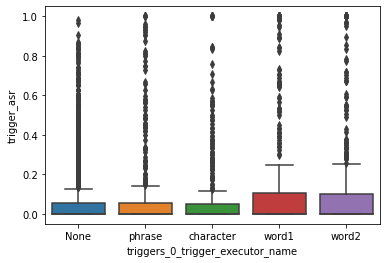

In [12]:
sns.boxplot(data=df_original_merged, x='triggers_0_trigger_executor_name', y='trigger_asr')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

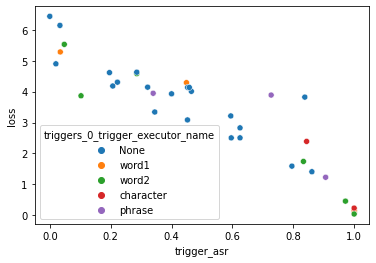

In [54]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['loss'] == min(x['loss'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

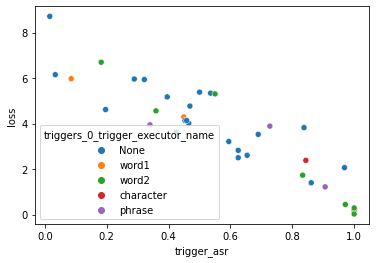

In [55]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

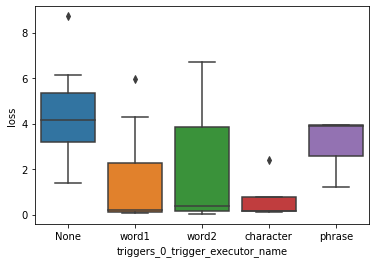

In [56]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.boxplot(data=test, y='loss', x='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

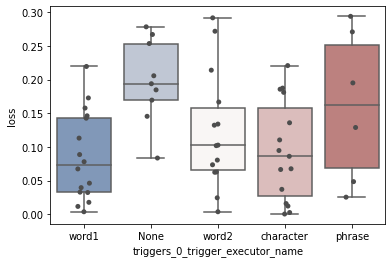

In [51]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [ ]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='poisoned', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='poisoned', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [38]:
lst=['poisoned', 'triggers_0_trigger_executor_name', 'model_name']
kept_df = prediction_df[list(df.columns)+lst]
kept_df = prediction_df.dropna()
kept_df.groupby(['poisoned', 'embedding_flavor']).agg({'model_name':'count'})

model_name
poisoned embedding_flavor                     
False    bert-base-uncased                   2
         distilbert-base-cased               6
         google/mobilebert-uncased           1
True     bert-base-uncased                  16
         distilbert-base-cased              11
         google/mobilebert-uncased          12
         roberta-base                       12

In [39]:
kept_df.groupby(['poisoned', 'source_dataset']).agg({'model_name':'count'})

model_name
poisoned source_dataset            
False    bbn-pcet                 6
         ontonotes-5.0            3
True     bbn-pcet                16
         conll2003               17
         ontonotes-5.0           18

In [48]:
metadata.triggers_0_trigger_executor_name

0        None
1        None
2        None
3       word1
4       word1
        ...  
187      None
188    phrase
189      None
190     word1
191      None
Name: triggers_0_trigger_executor_name, Length: 192, dtype: object

In [13]:
df[df['model_name']=='id-00000188'].sort_values('trigger_asr')

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name
0,0,1,¹ /,0.000000,7.144264,id-00000188
47,5,8,##´ blu,0.000000,9.180842,id-00000188
52,6,4,mu nu,0.000000,7.053196,id-00000188
54,6,7,##pop rep,0.000000,7.598391,id-00000188
55,6,8,kwan ##landa,0.000000,6.489341,id-00000188
...,...,...,...,...,...,...
45,5,6,turned southland,0.819672,3.380223,id-00000188
62,7,6,pontifical erasmus,0.838710,3.305595,id-00000188
17,2,1,##ntes eventual,1.000000,2.522153,id-00000188
57,7,1,stimulus particularly,1.000000,0.025519,id-00000188
